<a href="https://colab.research.google.com/github/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/blob/main/Notebooks/Reconocimiento_de_Entidades_Nombradas_mediante_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Cambiar el entorno de ejecución para trabajar con GPU

<h1> RECONOCIMIENTIO DE ENTIDADES NOMBRADAS

(NER, Named-Entity-Recognition)

* El término de **entidades nombradas** fue acuñado por primera vez en 1995 para referirse al proceso de extraer unidades relevantes de información a partir de textos no estructurados..
* Estas unidades incluyen nombres propios de personas, organizaciones, lugares o expresiones numéricas como fechas o
cantidades, etc.
*  El REN se utiliza en sistemas de Pregunta-Respuesta (QA), la generación de resúmenes automáticos, la mejora de los sistemas de recuperación de la información, la traducción automática, la anonimización de textos, la generación de
grafos de conocimientos, etc.
* En los últimos años, el uso de las redes neuronales con el aprendizaje profundo y la integración de modelos del lenguaje con los WordEmbeddings ha supuesto un cambio en el
paradigma del PLN en general y en las tareas específicas como NER


# 1.Cargar bibliotecas

In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim  # para cargar modelo w2v
from collections import Counter
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model


# 2.Leer Datos

In [3]:
csv_file ="https://raw.githubusercontent.com/AnIsAsPe/Named-Entity-Recognition-NER-con-LSTM-Bidireccionales/main/Datos/ner_datasetreference.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape', usecols =[0,1,3])
data = data.fillna( method='ffill', axis=0)  # copia en los NaN la última observación válida, hasta encontrar la siguiente.
data.head()

/tmp/ipython-input-2103271818.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna( method='ffill', axis=0)  # copia en los NaN la última observación válida, hasta encontrar la siguiente.


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [4]:
data.loc[:50,]

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [5]:
data.nunique()  # Valores únicos en cada columna

,0
Sentence #,47959
Word,35177
Tag,17


In [6]:
data.Tag.value_counts()

,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


* geo - Geographical Entity
* gpe - Geopolitical Entity
* per - Person
* org - Organization
* tim - Time indicator
* art - Artifact
* eve - Event
* nat - NaturalPhenomenon

[Inside-Outside-Beginning (tagging)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

In [7]:
data[data['Sentence #']=="Sentence: 66"]

,Sentence #,Word,Tag
1491,Sentence: 66,Energy,O
1492,Sentence: 66,",",O
1493,Sentence: 66,security,O
1494,Sentence: 66,",",O
1495,Sentence: 66,climate,O
1496,Sentence: 66,change,O
1497,Sentence: 66,",",O
1498,Sentence: 66,the,O
1499,Sentence: 66,World,B-org
1500,Sentence: 66,Trade,I-org


In [8]:
# promedio de palabras por sentencia
data.shape[0]/data['Sentence #'].nunique()

21.863987989741236

## 2.1.Pasar de tokens por renglón a la secuencia completa de la oración por renglón.

In [9]:
data['Sentence #'] = data['Sentence #'].str.replace('Sentence: ','').astype(int)
sentences = data.groupby(['Sentence #'],
                         as_index=False ).agg(lambda x: ' '.join(x))
sentences.columns=['ID', 'Sentence', 'Tags']

sentences.head(5)

,ID,Sentence,Tags
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...


# 3.Identificar cada token y cada etiqueta con un valor numérico

In [10]:
# modificamos el filtro que por default Tonkenizer utiliza para borrar puntuación
#  '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

custom_filters = ''
tokenizer = Tokenizer(filters=custom_filters, lower=False)
tokenizer.fit_on_texts(sentences['Sentence'])



# Convertir tags a numeros
tokenizer_tags = Tokenizer(filters=custom_filters, lower=False)
tokenizer_tags.fit_on_texts(sentences['Tags'])


In [11]:
# tokenizer reserva el indice 0 para padding y posibels tokens OOV (Out-of-vocabulary)
tokenizer_tags.word_index

{'O': 1,
 'B-geo': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-per': 5,
 'B-per': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'B-eve': 12,
 'I-art': 13,
 'I-eve': 14,
 'B-nat': 15,
 'I-gpe': 16,
 'I-nat': 17}

In [12]:
vocabulario_palabras = list(tokenizer.word_index.keys())
# vocabulario_tags = list(tokenizer_tags.word_index.keys())


In [13]:
sentences['Sentence_idx'] = tokenizer.texts_to_sequences(sentences['Sentence'])
sentences['Tags_idx'] = tokenizer_tags.texts_to_sequences(sentences['Tags'])
sentences

,ID,Sentence,Tags,Sentence_idx,Tags_idx
0,1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[1114, 4, 1161, 16, 1852, 229, 478, 6, 533, 1,...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ..."
1,2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...,"[8839, 4, 143, 37, 5, 1, 514, 1099, 1, 658, 53...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O,"[204, 1852, 21, 1, 15374, 4, 2175, 6, 7, 1306,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 9, 1]"
3,4,"Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O,"[261, 714, 1, 268, 4, 8179, 23, 2110, 203, 406...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,5,The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[9, 533, 544, 14, 1, 3953, 4, 1, 974, 526, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, ..."
...,...,...,...,...,...
47954,47955,Indian border security forces are accusing the...,B-gpe O O O O O O B-gpe O O O O O O O O O B-ge...,"[369, 186, 93, 77, 28, 2238, 57, 258, 4153, 4,...","[8, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, ..."
47955,47956,Indian officials said no one was injured in Sa...,B-gpe O O O O O O O B-tim O O O O O O O O O O ...,"[369, 41, 18, 132, 63, 19, 535, 5, 91, 10, 447...","[8, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ..."
47956,47957,Two more landed in fields belonging to a nearb...,O O O O O O O O O O O,"[694, 49, 2825, 5, 3253, 3506, 6, 7, 1223, 823...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
47957,47958,They say not all of the rockets exploded upon ...,O O O O O O O O O O O,"[204, 24, 39, 160, 4, 1, 1443, 753, 1507, 2054...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


# 4.Preparar las secuencias que ingresarán a nuestra red neuronal.

Padding: Las capas de LSTM necesitan que cada secuencias (oración) tenga la misma longitud, se puede usar cualquier longitud, pero entre más grande sea mayor será el costo del entrenamiento.

Las oraciones  que sean más cortas se "rellenaran" con el token que agregamos anterioremente ('PAD_token')


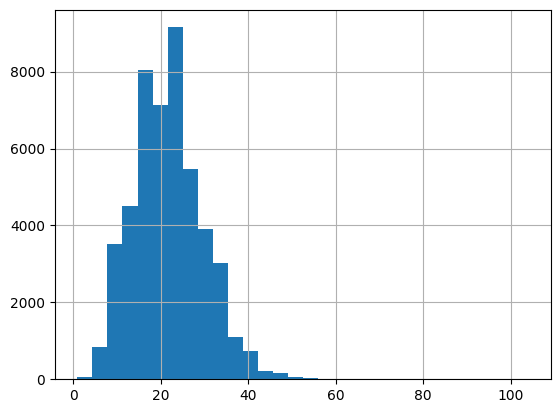

La oración más larga tiene 104 tokens


In [14]:

palabras_sentencia = sentences['Sentence'].apply(lambda x: len(str(x).split()))

palabras_sentencia.hist(bins=30)
plt.show()
print('La oración más larga tiene {} tokens'.format(palabras_sentencia.max()))

In [15]:
max_len = int(palabras_sentencia.quantile(0.95))
max_len

35

In [16]:
# Rellenar con ceros a la máxima longitud de los textos
pad_tokens = pad_sequences(sentences['Sentence_idx'], maxlen=max_len,
                           dtype='int32', padding='post',
                           )
pad_tags = pad_sequences(sentences['Tags_idx'], maxlen=max_len,
                         dtype='int32', padding='post',
                         )

# Hacemos un One Hot Encoding para la secuencia de etiquetas
pad_tags = [to_categorical(i, num_classes=18) for i in pad_tags]

## Ejemplo

In [17]:
ej = 9
longitud = len(sentences.loc[ej, 'Sentence'].split())

print(
f'''Longitud sentence: {longitud}
Longitud sentence_idx: {len(sentences.loc[ej, 'Sentence_idx'])}
Longitud tags: {len(sentences.loc[ej, 'Tags'])}
Longitud tags_idx: {len(sentences.loc[ej, 'Tags_idx'])}


{sentences.loc[ej, "Sentence"]}
{sentences.loc[ej, "Sentence_idx"]}

{sentences.loc[ej, "Tags"]}
{sentences.loc[ej, "Tags_idx"]}
'''
)

Longitud sentence: 25
Longitud sentence_idx: 25
Longitud tags: 61
Longitud tags_idx: 25


Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .
[319, 41, 24, 55, 1830, 6, 765, 1036, 6, 4659, 3339, 795, 4, 1, 1179, 83, 3, 44, 27, 1705, 2277, 470, 2278, 6326, 2]

B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O 
[8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1]



In [18]:
pad_tokens[ej]

array([ 319,   41,   24,   55, 1830,    6,  765, 1036,    6, 4659, 3339,
        795,    4,    1, 1179,   83,    3,   44,   27, 1705, 2277,  470,
       2278, 6326,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [19]:
for token, tag in zip(pad_tokens[ej], pad_tags[ej]):
    print('%s\t%s' % (token, tag))

319	[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
41	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
24	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
55	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1830	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
765	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1036	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4659	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3339	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
795	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1179	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
83	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# 5.Obtener la matriz de encajes para todas las palabras del vocabulario

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés.
Crea un acceso directo en tu drive del modelo preentrenado que está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Si es la primera vez que corres el notebook, descomenta las siguientes lineas para cargar el modelo preentrenado completo.

In [21]:
%%time
# asegurate de poner la ruta correcta en donde se ubica el archivo en tu drive
file =  '/content/drive/MyDrive/Embeddings/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

CPU times: user 52.5 s, sys: 4.04 s, total: 56.6 s
Wall time: 57.7 s


In [22]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.key_to_index)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


<h3> Reducción del diccionario de embeddings para tener solo los tokens presentes en nuestro corpus.

Guardar en pikle
Así no tendremos que volver a cargar todo el modelo word embedding

In [23]:
dic_tokens_word2vec  = {}
palabras_sin_embedding =[]
for token in vocabulario_palabras:
  try:
    dic_tokens_word2vec[token] = w2v[token]
  except:
    palabras_sin_embedding.append(token)

In [124]:
import pickle
path = '/content/drive/MyDrive/Pikles'
pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [25]:
# import pickle
# path = '/content/drive/MyDrive/Pikles'
# dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))
# palabras_sin_embedding = [tok for tok in data.Word.unique() if tok not in dic_tokens_word2vec.keys()]


In [26]:
len(vocabulario_palabras)

35177

In [27]:
len(palabras_sin_embedding)

6276

In [28]:
# Tokens más frecuentes sin embbedding en nuestros datos.
frec_tokens = pd.DataFrame.from_dict(tokenizer.word_counts, orient='index')
frec_tokens.loc[palabras_sin_embedding].sort_values(by=0, ascending=False).head(35)

,0
.,47771
",",32754
of,26354
to,23213
a,20481
and,19936
's,10923
"""",3686
-,1172
),665


In [73]:

num_tokens

35178

In [123]:
token_index = tokenizer.word_index
token_index['PAD_TOKEN'] = 0
num_tokens = len(token_index.keys())

embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token_index.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]


In [56]:
pd.DataFrame(embedding_matrix, index=['PAD_TOKEN']+vocabulario_palabras)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
PAD_TOKEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
the,0.080078,0.104980,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.071289,-0.030151,-0.013000,0.016357,-0.018311,0.014832,0.005005,0.003662,0.047607,-0.068848
.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
",",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
of,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
four-star,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hardliner,0.351562,0.126953,0.246094,0.275391,-0.005493,0.090820,-0.241211,0.049316,0.128906,0.215820,...,-0.147461,0.008728,-0.047363,-0.006042,-0.042236,-0.034668,-0.133789,-0.100098,0.077148,0.457031
indicative,-0.527344,0.086426,-0.035400,0.003342,-0.003418,0.086914,0.199219,-0.152344,0.247070,0.158203,...,-0.332031,0.141602,0.033447,0.006104,0.240234,-0.005829,-0.159180,-0.169922,0.054932,-0.233398
3700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 6.Dividir en conjunto de entrenamiento y prueba

In [39]:
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
f'''train_tokens: {len(train_tokens)}
train_tags: {len(train_tags)}

test_tokens: {len(test_tokens)}
test_tags: {len(test_tags)}'''
)

train_tokens: 43163
train_tags: 43163

test_tokens: 4796
test_tags: 4796


# 7.Construcción de la Arquitectura del Modelo


- **Embedding layer** : Será la primera capa de nuestro modelo en el que ingresaremos las secuencias todas de tamaño 50. Esta capa no la entrenaremos (training = False), sino que en su lugar la alimentaremos con la matriz de embedings que preparamos en el paso 5. La salida de esa capa será un tensor de tres dimensiones para alimentar a la capa LSTM [Bath size, timesteps, features] que en nuestro caso se traducirá en [None, 50, 300]

- **Bidirectional LSTM** : Tomará la salida de la capa de embedings y concatenará las salidas de las dos direcciones del LSTM, cada salida tendra las unidades que se declaren en la capa LSTM (128) y al concatenarse, la salida será del doble de unidades (None, 50, 256)

- **TimeDistributed  Layer** : La arquitectura de nuestra RNN es de tipo muchas a muchas, en donde para cada token (timestep) de la secuencia de entrada, esperamos la probabilidad de pertenencia a cada  una de las clases. Para ello se usa esta capa activada por la función 'Softmax'. La salida de esta capa será un tensor de (None, 50, 17)

In [40]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [42]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units=128,
                             return_sequences=True, # Todos los estados h para cada timestep
                             recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa de Salida
out = TimeDistributed(
    Dense(18,               # dimensiones de salida (17 clases de los Tags + PAD_TAG)
          activation="softmax"  # para obtener una probabilidad para cada clase
                                # función de activación
                                # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          ))(LSTM_Bi)

NER_model = Model(input, out)  # unión del modelo
NER_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 35, 300)        │    10,553,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 35, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 35, 18)         │         4,626 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,997,322 (41.95 MB)

 Trainable params: 443,922 (1.69 MB)

 Non-trainable params: 10,553,400 (40.26 MB)

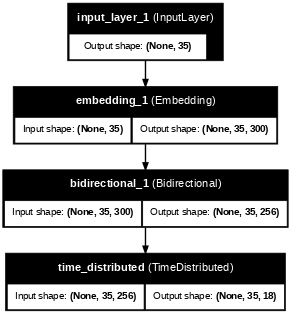

In [43]:
plot_model(
    NER_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# 8.Entrenamiento del modelo

In [44]:
# Compile model
NER_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [45]:
type(train_tags)

list

In [107]:
history = NER_model.fit(train_tokens, np.array(train_tags),
                        validation_split=0.2,
                        batch_size=200,
                        epochs=10,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 138s 797ms/step - accuracy: 0.9709 - loss: 0.1034 - val_accuracy: 0.9726 - val_loss: 0.0951
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 137s 772ms/step - accuracy: 0.9718 - loss: 0.0985 - val_accuracy: 0.9733 - val_loss: 0.0916
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 145s 787ms/step - accuracy: 0.9727 - loss: 0.0947 - val_accuracy: 0.9740 - val_loss: 0.0889
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 789ms/step - accuracy: 0.9737 - loss: 0.0911 - val_accuracy: 0.9745 - val_loss: 0.0867
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 797ms/step - accuracy: 0.9743 - loss: 0.0880 - val_accuracy: 0.9750 - val_loss: 0.0844
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 806ms/step - accuracy: 0.9749 - loss: 0.0857 - val_accuracy: 0.9753 - val_loss: 0.0827
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 136s 785ms/step - accuracy: 0.9753 - loss: 0.0837 - val_accuracy: 0.9758 - val_loss: 0.0812
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 134s 778ms/step - accuracy: 0.9757 -

In [108]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
NER_model.save_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct25.weights.h5')

In [109]:
# Leer el modelo guardado
NER_model.load_weights('/content/drive/MyDrive/Modelos/Weights_NER_oct25.weights.h5')

# 9.Predicción y Evaluación

In [110]:
test_pred = NER_model.predict(np.array(test_tokens), verbose=1)

150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step


In [111]:
# Dimensiones de entrada
test_tokens[0]

array([   59,    69,   180,     3,     7,  2621,   111,    78,    37,
          63,   969,     5,     1,   130,   141,  2048,     4, 24070,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [112]:
# Dimensiones de salida
test_pred.shape

(4796, 35, 18)

In [113]:
test_pred[0].shape

(35, 18)

In [114]:
pd.DataFrame(test_pred[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,8.558694e-09,0.999857,1.874058e-05,4.258769e-05,1.673953e-05,5.261092e-06,7.610537e-06,8.171871e-06,1.472560e-06,1.014827e-05,1.573264e-05,3.601077e-06,7.251827e-07,6.339653e-06,2.477970e-06,1.243947e-06,5.580142e-07,1.073205e-06
1,1.033842e-09,0.999264,2.785179e-05,6.081650e-04,6.948811e-06,3.286083e-07,7.872637e-06,6.824700e-07,8.037372e-06,7.773015e-07,6.238966e-05,8.654221e-06,1.119613e-06,5.414060e-07,6.015791e-07,1.562829e-06,3.757971e-07,3.096699e-07
2,7.747134e-10,0.999721,1.530172e-05,9.582638e-05,2.364719e-05,4.530707e-07,2.134280e-05,4.369163e-07,7.375408e-07,8.772582e-07,8.844508e-05,2.664964e-05,1.756228e-06,1.155648e-06,8.039448e-07,1.505525e-06,1.071693e-07,3.672085e-07
3,1.061007e-07,0.998256,1.767314e-04,4.096569e-04,7.395514e-04,3.517335e-06,2.087626e-04,3.517570e-06,1.396463e-05,9.946722e-06,9.139573e-05,5.126229e-05,4.676523e-06,2.527592e-06,2.813292e-06,2.419375e-05,6.130596e-07,1.127102e-06
4,2.331173e-04,0.993850,7.532858e-04,1.765180e-03,1.622091e-03,1.879765e-05,4.228215e-04,7.454870e-05,7.584742e-05,1.178514e-05,6.522171e-04,2.595690e-04,3.024783e-05,1.363451e-05,2.330171e-05,1.831487e-04,2.298200e-06,8.638416e-06
5,1.500837e-07,0.999178,1.143440e-05,5.339740e-05,2.960014e-05,9.957664e-06,2.656041e-05,9.546129e-06,2.366172e-06,6.576805e-07,6.185264e-04,1.821081e-05,1.296838e-05,3.436026e-06,1.603674e-05,4.573216e-06,8.627486e-07,3.380588e-06
6,1.760912e-10,0.999881,1.397924e-06,5.200567e-05,1.433437e-06,6.959078e-08,1.538124e-06,2.784008e-07,4.989933e-08,3.534110e-08,5.953491e-05,9.342853e-07,7.613381e-07,1.795169e-07,5.292327e-07,3.623604e-07,1.648612e-08,8.303103e-08
7,1.017792e-09,0.001273,2.114003e-05,9.973991e-01,5.679522e-06,8.047139e-08,1.645770e-06,4.651148e-08,6.291539e-08,7.486408e-08,1.295609e-03,8.923317e-07,1.932352e-06,6.609530e-08,4.464231e-07,3.388508e-07,8.349744e-09,7.419356e-08
8,3.094233e-11,0.999987,8.480097e-07,1.652280e-07,3.842355e-07,5.874935e-08,3.334112e-07,5.988512e-08,6.007248e-07,6.553726e-08,9.713096e-06,2.001426e-07,7.777549e-08,5.007484e-08,8.736231e-08,1.086112e-07,1.464131e-08,1.729606e-08
9,2.888783e-10,0.999759,1.224422e-05,1.999522e-04,6.053623e-06,4.647789e-08,4.165548e-06,3.070748e-08,9.342129e-07,3.577641e-08,1.371267e-05,1.686101e-06,2.646308e-07,9.073915e-08,2.191516e-07,1.046551e-06,2.465148e-08,8.446857e-08


In [115]:
test_tokens[0:2] # Primeras dos secuencias de entrada en test

array([[   59,    69,   180,     3,     7,  2621,   111,    78,    37,
           63,   969,     5,     1,   130,   141,  2048,     4, 24070,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  320,   709,   154,     3,  2308,   304, 10023, 10024,     3,
           20,     1,    34,    13,   433,     6,  1861,    99,    53,
          474,     1,  3811,     3,    56,  2465,    15,     1,   122,
           10,  1157,    19,    39,     1,  2057,  1537,     2]],
      dtype=int32)

In [116]:
 test_tokens[0,1] #  M[i, j]

69

In [117]:
test_tokens.shape

(4796, 35)

In [118]:
# Obtener el diccionario index_token
index_token = {idx: token for token, idx in token_index.items()}

# Obtener el diccionario index_tag
tag_index = tokenizer_tags.word_index
tag_index['PAD_TAG'] = 0
index_tag = {i: w for w, i in tag_index.items()}


In [119]:
def secIdx2secTok(M):
  '''
  Obtiene para cada secuencia de tokens codificada con un indice,
  la secuencia de tokens decodificada
  Argumentos:
  ----------
  M: Matriz de la forma (n_sec, max_len)

  Regresa las secuencias de tokens decodificada.'''

  n = M.shape[0]
  d = M.shape[1]
  oraciones = []
  for i in range(n):
      tokens = []
      for j in range(d):
          idx = M[i, j]
          tokens.append(index_token[idx])
      oraciones.append(tokens)
  return oraciones

test_toks = secIdx2secTok(test_tokens)


In [120]:

def secIdx2secTag(tensor_tag):
    '''
    Obtiene para cada secuencia de etiquetas codificada con un indice,
    la secuencia de etiquetas decodificadas.
    Argumentos:
    ----------
    tensor_tag: un tensor de la forma (n_sec, max_len, 18)

    Regresa las secuencias de etiquetas decodificada.
    '''
    lista_sec_decodificadas = []
    for sec in tensor_tag:
        tags = []
        for p in sec:
            inx = np.argmax(p)
            tags.append(index_tag[inx])
        lista_sec_decodificadas.append(tags)
    return lista_sec_decodificadas

pred_labels = secIdx2secTag(test_pred)
test_labels = secIdx2secTag(test_tags)

In [121]:
dfs = {}
for idx in range(len(test_labels)):
  dfs[idx] = pd.DataFrame({'ID': idx,
                           'Word': test_toks[idx],
                           'Tag':test_labels[idx],
                           'Pred':pred_labels[idx]})

resultados = pd.concat(dfs, ignore_index = True).set_index('ID')
resultados = resultados[resultados['Word']!='PAD_TOKEN']
resultados['acierto'] = np.where(resultados['Pred']==resultados['Tag'],1,0)
resultados['acierto'].mean()

0.9637120418344884

In [122]:
resultados.loc[312]  # 4 , 8 , 87

,Word,Tag,Pred,acierto
ID,,,,
312,Attorney,O,O,1
312,General,B-per,B-per,1
312,Mukasey,I-per,I-per,1
312,was,O,O,1
312,formally,O,O,1
312,sworn,O,O,1
312,in,O,O,1
312,Wednesday,B-tim,B-tim,1
312,at,O,O,1


# Referencias

1. Karakaya M. LSTM: Understanding Output Types [Internet]. Deep Learning Tutorials with Keras. 2021 [citado 14 de julio de 2022]. Disponible en: https://www.muratkarakaya.net/2022/11/lstm-understanding-output-types.html



2. Nair S. Named-Entity Recognition (NER) using Keras Bidirectional LSTM [Internet]. Medium. 2020 [citado 14 de julio de 2022]. Disponible en: https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

3. Samy D. Reconocimiento y clasificación de entidades nombradas en textos legales en español. Procesamiento del Lenguaje Natural. 2021;103-14.

4. Sarkar S. Named Entity Recognition using Deep Learning(ELMo Embedding+ Bi-LSTM) [Internet]. Analytics Vidhya. 2021 [citado 14 de julio de 2022]. Disponible en: https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab







